<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Landmarks_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from PIL import Image
from sklearn.cluster import SpectralClustering

import warnings
warnings.filterwarnings('ignore')

# 2. Load points

In [3]:
with open("datasets/cropped_helen/helen_cropped_train_pts.json",'r') as load_crop_train:
  crop_pts_train = json.load(load_crop_train)

In [4]:
train_points = torch.zeros(2000,68,2)
i = 0
for key in crop_pts_train.keys():
  train_points[i,:,:] = torch.tensor(crop_pts_train[key])
  i+=1

Text(0.5, 1.0, 'Locations of the first point')

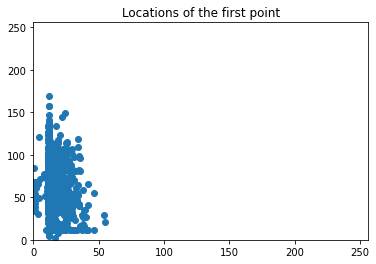

In [5]:
x = train_points[:,0,0]
y = train_points[:,0,1]
plt.scatter(x,y)
plt.xlim(0,256)
plt.ylim(0,256)
plt.title('Locations of the first point')

In [6]:
def occurance_heatmap(ind, grid=4):
  # input grid and index of the point, outputs occurance heatmap

  hlen = int(256/grid)
  occ_heatmap = torch.zeros(hlen,hlen)
  for i in range(2000):
    x = train_points[i,ind,0]
    y = train_points[i,ind,1]
    indx = int(x//grid)
    indy = int(y//grid)
    if indx == hlen:
      indx -= 1
    if indy == hlen:
      indy -= 1
    occ_heatmap[indx,indy] += 1
  return occ_heatmap/torch.sum(occ_heatmap)

# 3. Spectral Clustering

In [7]:
W = torch.zeros(68,68)
for p1 in range(68):
  hm1 = occurance_heatmap(p1)
  for p2 in range(p1+1,68):
    hm2 = occurance_heatmap(p2)
    psum = torch.sum(hm1*hm2)
    W[p1,p2] = W[p2,p1] = torch.log(psum+1e-8)*psum
W = W/torch.sum(W)

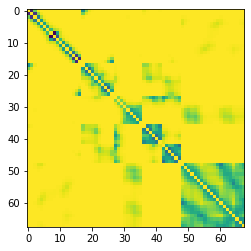

In [8]:
plt.imshow(1-W)

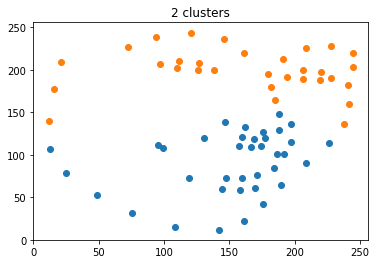

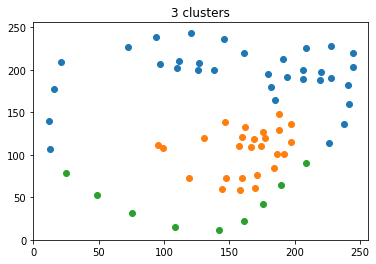

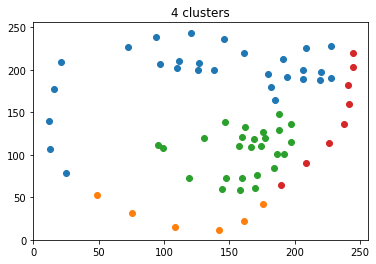

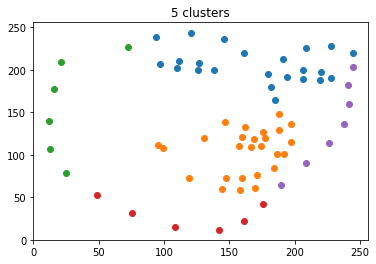

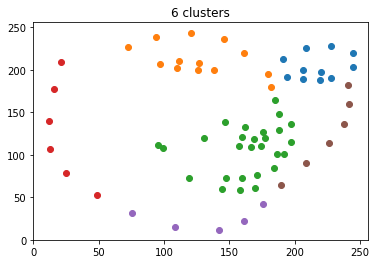

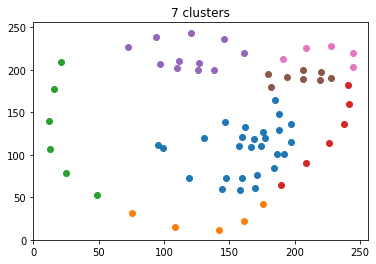

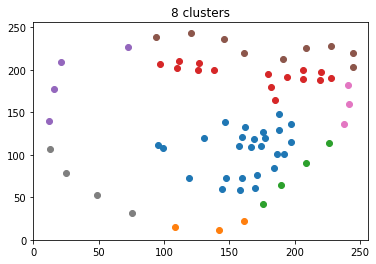

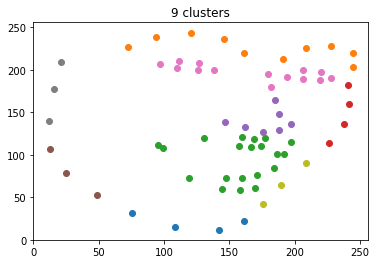

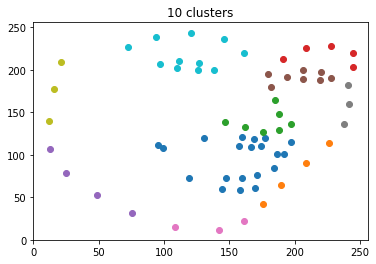

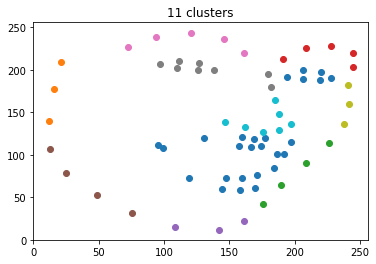

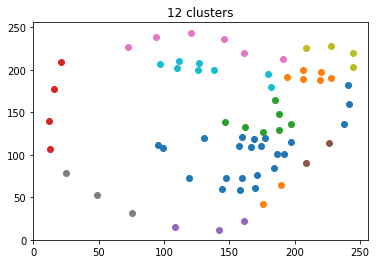

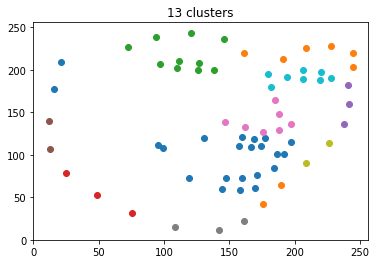

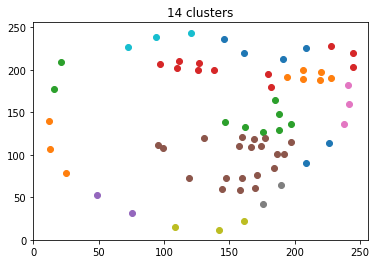

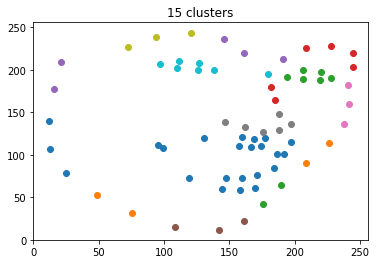

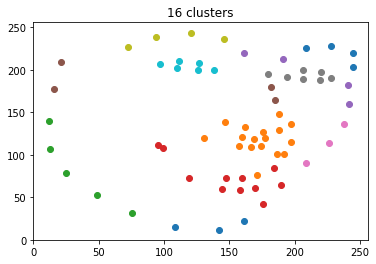

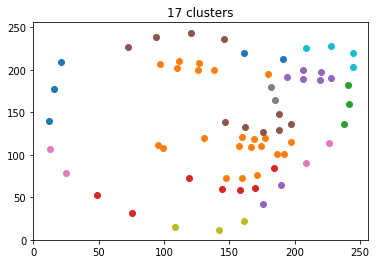

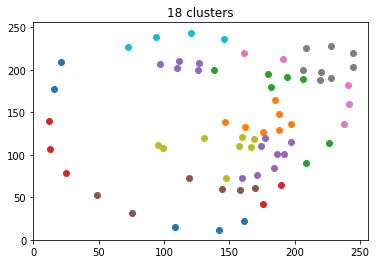

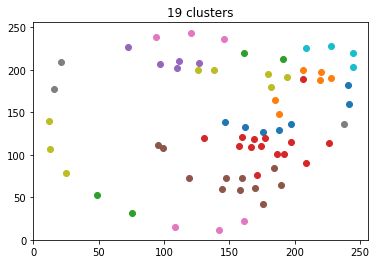

In [9]:
for Cluster in range(2,20):
  y_pred = SpectralClustering(n_clusters=Cluster, affinity = 'precomputed').fit_predict(W)

  for c in range(Cluster):
    x = train_points[0,:,0][y_pred==c]
    y = train_points[0,:,1][y_pred==c]
    plt.scatter(x,256-y)
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(Cluster)+' clusters')
  plt.show()